<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Подготовка-признаков-перед-обучением" data-toc-modified-id="Подготовка-признаков-перед-обучением-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Подготовка признаков перед обучением</a></span></li><li><span><a href="#RandomForestRegressor" data-toc-modified-id="RandomForestRegressor-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>RandomForestRegressor</a></span></li><li><span><a href="#CatBoostRegressor" data-toc-modified-id="CatBoostRegressor-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>CatBoostRegressor</a></span></li><li><span><a href="#XGBRegressor" data-toc-modified-id="XGBRegressor-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>XGBRegressor</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.

## Подготовка

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from matplotlib.ticker import NullLocator, LinearLocator, MultipleLocator, IndexLocator

In [3]:
df = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [4]:
df.index.is_monotonic

True

In [4]:
df.isna().sum()

num_orders    0
dtype: int64

In [5]:
df = df.resample('1H').sum()

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


In [8]:
df.head(1), df.tail(1)

(            num_orders
 datetime              
 2018-03-01         124,
                      num_orders
 datetime                       
 2018-08-31 23:00:00         205)

У нас есть данные по загрузке такси в за каждый час каждого дня с 2018-03-01 по 2018-08-31. Пропуски не обнаружены, среди индексов дубликатов не обнаружено. Переходим к анализу.

## Анализ

Посмотрим распределение такси на графике за три любые три дня

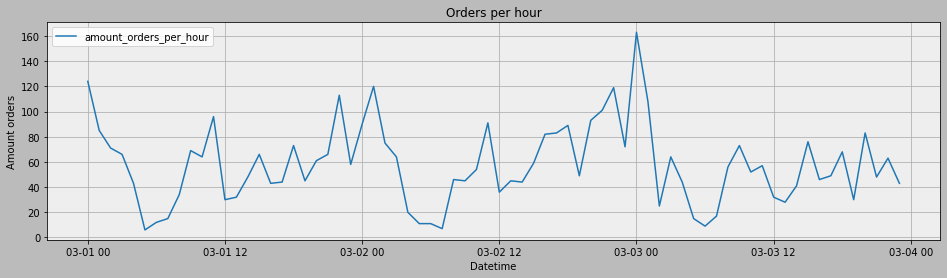

In [9]:
fig = plt.figure(figsize=(16, 4), facecolor='#bbb')
ax = fig.add_subplot(facecolor='#eee')
ax.plot(df['2018-03-01':'2018-03-03'].resample('1h').sum(), label='amount_orders_per_hour')
plt.grid()
plt.title('Orders per hour')
plt.xlabel('Datetime')
plt.ylabel('Amount orders')
plt.legend(loc='upper left');

Добавим сглаживание за 3, 6 и 12 часов.

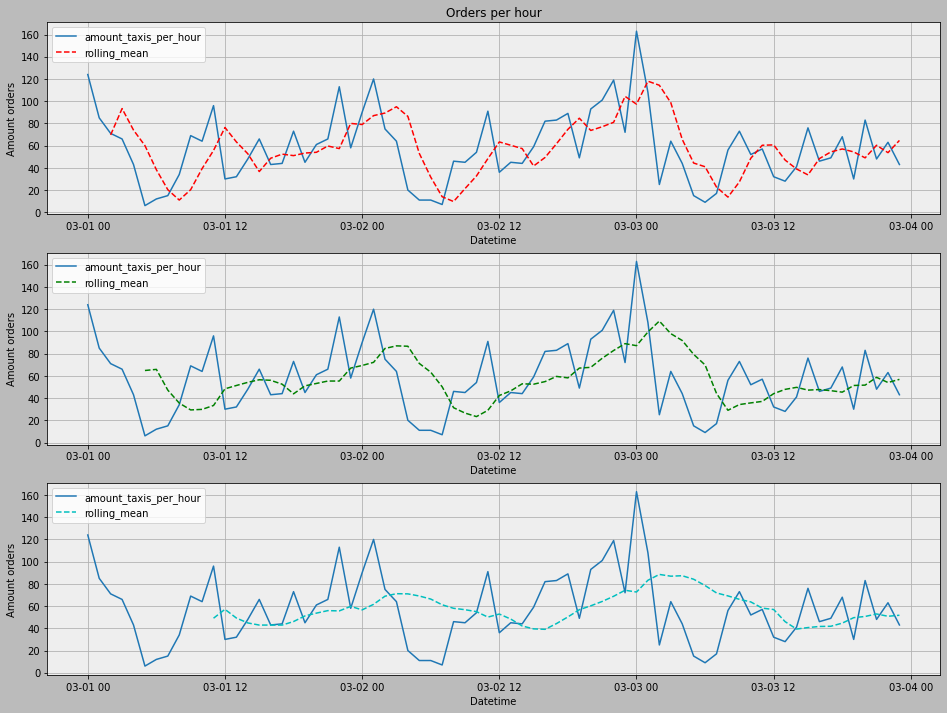

In [10]:
fig, ax = plt.subplots(3, 1)
fig.set_size_inches(16, 12)
fig.set_facecolor('#bbb')


ax1 = plt.subplot(311, facecolor='#eee')
plt.plot(df['2018-03-01':'2018-03-03'].resample('1h').sum(), label='amount_taxis_per_hour')
plt.plot(df['2018-03-01':'2018-03-03'].shift(1).resample('1h').sum().rolling(3).mean(), 'r--', label='rolling_mean')
plt.grid()
plt.title('Orders per hour')
plt.xlabel('Datetime')
plt.ylabel('Amount orders')
plt.legend(loc='upper left')

ax2 = plt.subplot(312, facecolor='#eee')
plt.plot(df['2018-03-01':'2018-03-03'].resample('1h').sum(), label='amount_taxis_per_hour')
plt.plot(df['2018-03-01':'2018-03-03'].shift(1).resample('1h').sum().rolling(6).mean(), 'g--', label='rolling_mean')
plt.grid()
plt.xlabel('Datetime')
plt.ylabel('Amount orders')
plt.legend(loc='upper left')

ax2 = plt.subplot(313, facecolor='#eee')
plt.plot(df['2018-03-01':'2018-03-03'].resample('1h').sum(), label='amount_taxis_per_hour')
plt.plot(df['2018-03-01':'2018-03-03'].shift(1).resample('1h').sum().rolling(12).mean(), 'c--', label='rolling_mean')
plt.grid()
plt.xlabel('Datetime')
plt.ylabel('Amount orders')
plt.legend(loc='upper left');

Из графиков видно, что 3 часа дает слабое сглаживание, 12 слишком сильное, а 6 оптимальное. Проверим тренды и сезонность.

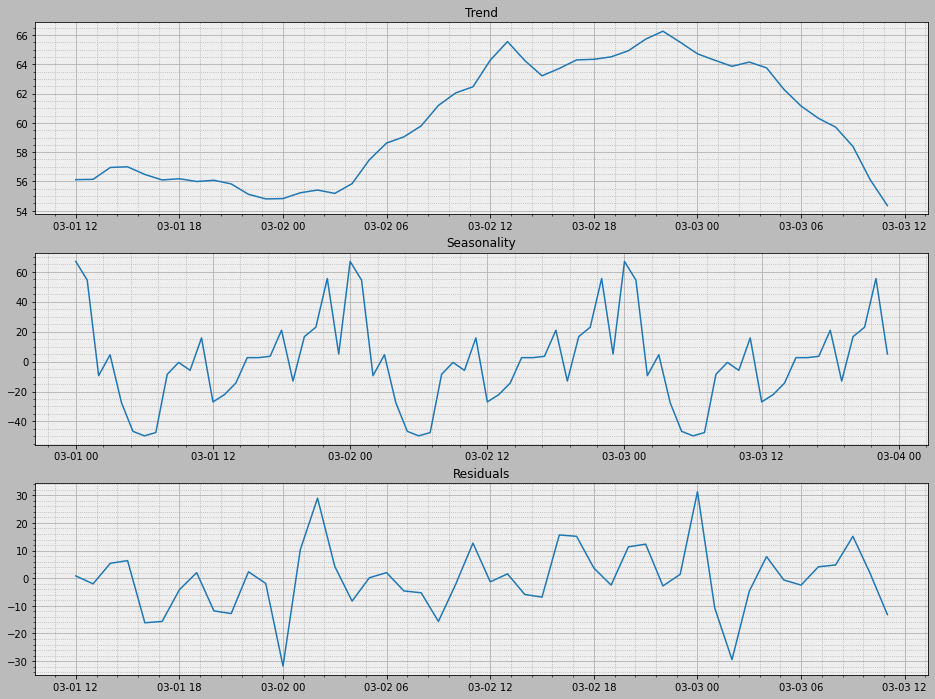

In [11]:
decomposed = seasonal_decompose(df['2018-03-01':'2018-03-03'])
fig, ax = plt.subplots(3, 1)
fig.set_size_inches(16, 12)
fig.set_facecolor('#bbb')

ax1 = plt.subplot(311, facecolor='#eee')
plt.plot(decomposed.trend)
plt.minorticks_on()
plt.title('Trend')
plt.grid(which='major')
plt.grid(which='minor', linestyle=':')

ax2 = plt.subplot(312, facecolor='#eee')
plt.plot(decomposed.seasonal)
plt.minorticks_on()
plt.title('Seasonality')
plt.grid(which='major')
plt.grid(which='minor', linestyle=':')

ax3 = plt.subplot(313, facecolor='#eee')
plt.plot(decomposed.resid)
plt.minorticks_on()
plt.title('Residuals')
plt.grid(which='major')
plt.grid(which='minor', linestyle=':');

В пределах суток определенно присутствует сезонность, есть 4 пиковыч часа, а также сильно меняется тренд. Проверим сезонность в рамках недели.

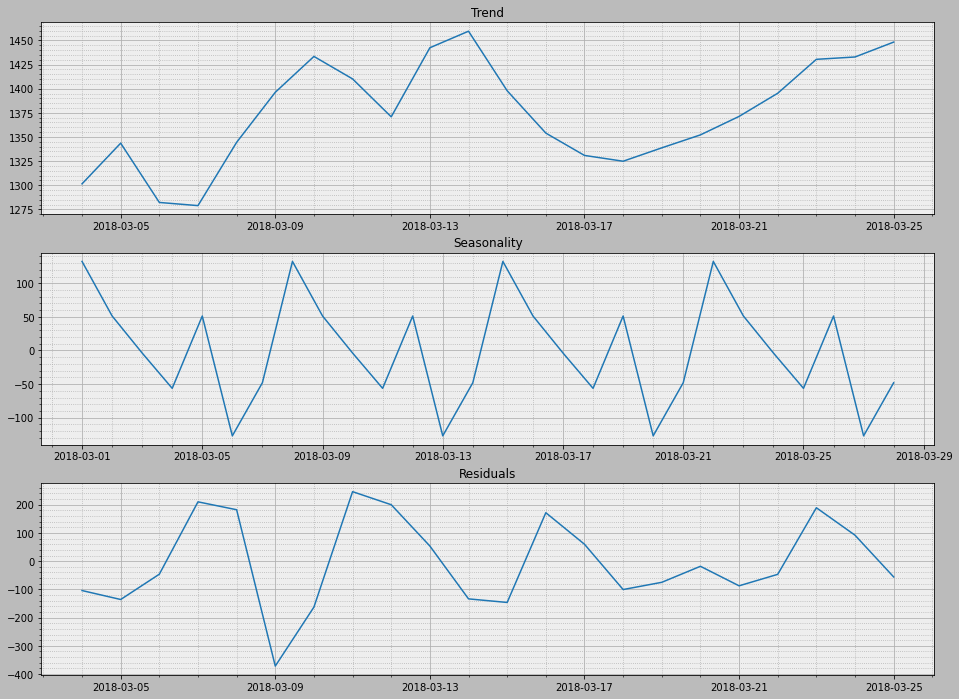

In [12]:
decomposed = seasonal_decompose(df['2018-03-01':'2018-03-28'].resample('1D').sum())
fig, ax = plt.subplots(3, 1)
fig.set_size_inches(16, 12)
fig.set_facecolor('#bbb')

ax1 = plt.subplot(311, facecolor='#eee')
plt.plot(decomposed.trend)
plt.minorticks_on()
plt.title('Trend')
plt.grid(which='major')
plt.grid(which='minor', linestyle=':')

ax2 = plt.subplot(312, facecolor='#eee')
plt.plot(decomposed.seasonal)
plt.minorticks_on()
plt.title('Seasonality')
plt.grid(which='major')
plt.grid(which='minor', linestyle=':')

ax3 = plt.subplot(313, facecolor='#eee')
plt.plot(decomposed.resid)
plt.minorticks_on()
plt.title('Residuals')
plt.grid(which='major')
plt.grid(which='minor', linestyle=':');

В рамках недели сеззоность также имеется и тренд меняется стремительно, поэтому в признаки будем брать не только предыдущий час, но и такой же час предыдущего дня и такой же час такого же дня недели предыдущей недели.

## Обучение

### Подготовка признаков перед обучением 

Напишем функцию для создания новых признаков

In [13]:
def get_features(data):
    data['dayofweek'] = data.index.dayofweek
    
    data['lag_1h'] = data['num_orders'].shift(1)
    data['lag_1d'] = data['num_orders'].shift(24)
    data['lag_1w'] = data['num_orders'].shift(168)
    
    data['rolling_mean'] = data['num_orders'].shift(1).rolling(3).mean()

Функция готова, создадим новые признаки

In [14]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [15]:
get_features(df)

In [16]:
df.head()

,num_orders,dayofweek,lag_1h,lag_1d,lag_1w,rolling_mean
datetime,,,,,,
2018-03-01 00:00:00,124,3,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,124.0,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,85.0,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,71.0,NaN,NaN,93.333333
2018-03-01 04:00:00,43,3,66.0,NaN,NaN,74.000000


Новые признаки получены, уберем пустые значения и подготовим выборки для обучения.

In [17]:
df = df.dropna()

In [18]:
df.head()

,num_orders,dayofweek,lag_1h,lag_1d,lag_1w,rolling_mean
datetime,,,,,,
2018-03-08 00:00:00,143,3,94.0,100.0,124.0,109.666667
2018-03-08 01:00:00,78,3,143.0,121.0,85.0,121.333333
2018-03-08 02:00:00,65,3,78.0,24.0,71.0,105.000000
2018-03-08 03:00:00,68,3,65.0,66.0,66.0,95.333333
2018-03-08 04:00:00,60,3,68.0,73.0,43.0,70.333333


In [19]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)
X_train = train.drop('num_orders', axis=1)
y_train = train['num_orders']
X_test = test.drop('num_orders', axis=1)
y_test = test['num_orders']

In [20]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((3823, 5), (3823,), (425, 5), (425,))

### RandomForestRegressor

In [21]:
params_rfr = {'n_estimators': [100, 200, 300], 
              'max_depth':[5, 7, 9]}

In [22]:
rfr = RandomForestRegressor(random_state=42)
cv_rfr = TimeSeriesSplit(n_splits=8).split(X_train)

In [23]:
grid_rfr = GridSearchCV(rfr, param_grid=params_rfr, scoring='neg_root_mean_squared_error', 
                   cv=cv_rfr, n_jobs=-1)

In [24]:
grid_rfr.fit(X_train, y_train)

GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x7f84cf56b270>,
             estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [5, 7, 9],
                         'n_estimators': [100, 200, 300]},
             scoring='neg_root_mean_squared_error')

In [25]:
best_param_rfr = pd.DataFrame(grid_rfr.cv_results_).sort_values(by='rank_test_score').head(1)
best_param_rfr = best_param_rfr[['mean_fit_time', 'mean_score_time', 'params', 'mean_test_score']]
best_param_rfr

,mean_fit_time,mean_score_time,params,mean_test_score
2,0.825526,0.03045,"{'max_depth': 5, 'n_estimators': 300}",-23.403987


### CatBoostRegressor

In [26]:
params_cbr = {'n_estimators': [100, 200, 300],
              'max_depth':[5, 7, 9],
              'learning_rate': [0.1, 0.3]}

In [27]:
cbr = CatBoostRegressor(random_state=42, verbose=False)
cv_cbr = TimeSeriesSplit(n_splits=5)

In [28]:
grid_cbr = GridSearchCV(cbr, param_grid=params_cbr, scoring='neg_root_mean_squared_error', 
                   cv=cv_cbr, n_jobs=-1)

In [29]:
grid_cbr.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=<catboost.core.CatBoostRegressor object at 0x7f84cf2de550>,
             n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.3], 'max_depth': [5, 7, 9],
                         'n_estimators': [100, 200, 300]},
             scoring='neg_root_mean_squared_error')

In [30]:
best_param_cbr = pd.DataFrame(grid_cbr.cv_results_).sort_values(by='rank_test_score').head(1)
best_param_cbr = best_param_cbr[['mean_fit_time', 'mean_score_time', 'params', 'mean_test_score']]
best_param_cbr

,mean_fit_time,mean_score_time,params,mean_test_score
0,0.496345,0.002005,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",-23.487077


### XGBRegressor

In [31]:
params_xgbr = {'n_estimators': [100, 200, 300],
               'max_depth':[5, 7, 9],
               'learning_rate': [0.1, 0.3]}

In [32]:
xgbr = XGBRegressor(random_state=42)
cv_xgbr = TimeSeriesSplit(n_splits=5)

In [33]:
grid_xgbr = GridSearchCV(xgbr, param_grid=params_xgbr, scoring='neg_root_mean_squared_error', 
                         cv=cv_xgbr, n_jobs=-1)

In [34]:
grid_xgbr.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    enable_categorical=False, gamma=None,
                                    gpu_id=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth...
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=None,
                                    num_parallel_tree=None, predictor=None,
                                    random_state=42, reg_alpha=None,
                                    reg_l

In [35]:
best_param_xgbr = pd.DataFrame(grid_xgbr.cv_results_).sort_values(by='rank_test_score').head(1)
best_param_xgbr = best_param_xgbr[['mean_fit_time', 'mean_score_time', 'params', 'mean_test_score']]
best_param_xgbr

,mean_fit_time,mean_score_time,params,mean_test_score
0,73.11319,0.037956,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",-24.996984


## Тестирование

In [36]:
result = pd.concat([best_param_rfr, best_param_cbr, best_param_xgbr], ignore_index=True, axis=0)
result.index=['RandomForestRegressor','CatBoostRegressor', 'XGBRegressor']
result.mean_test_score = result.mean_test_score * -1
result

,mean_fit_time,mean_score_time,params,mean_test_score
RandomForestRegressor,0.825526,0.030450,"{'max_depth': 5, 'n_estimators': 300}",23.403987
CatBoostRegressor,0.496345,0.002005,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",23.487077
XGBRegressor,73.113190,0.037956,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",24.996984


Модель с лучшей RMSE, а также лучшим временем обучения и предскания - CatBoostRegressor. Посмотрим какие признаки больше всего влияли на обучения и протестируем модель на тестовой выборке.

In [37]:
grid_cbr.best_estimator_.feature_importances_

array([ 2.42046193, 10.90723897, 22.6874924 , 57.48891713,  6.49588957])

In [38]:
ft_im = pd.Series(grid_cbr.best_estimator_.feature_importances_,
                         df.drop('num_orders', axis=1).columns).sort_values(ascending=False)

In [39]:
ft_im

lag_1w          57.488917
lag_1d          22.687492
lag_1h          10.907239
rolling_mean     6.495890
dayofweek        2.420462
dtype: float64

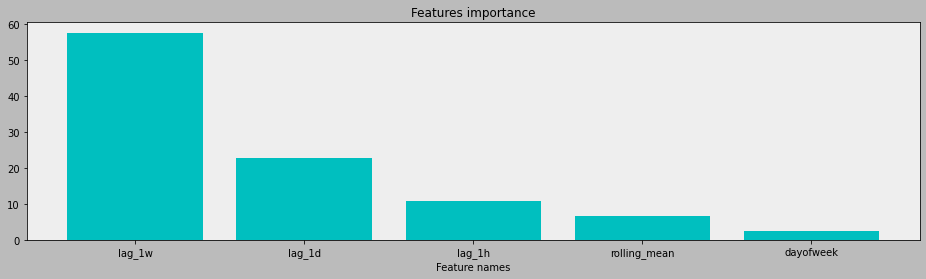

In [40]:
fig = plt.figure(figsize=(16, 4), facecolor='#bbb')
ax = fig.add_subplot(facecolor='#eee')
ax.bar(ft_im.index, ft_im, color="c")
plt.title('Features importance')
plt.xlabel('Feature names');

Сильнее всего при обучении модели повлиял признак, в котором находятся данные за такой же день прошлой недели, при таком небольшом наборе данных год оказался бесполезен. Протестируем модель на тестовой выборке и посмотрим на ошибку.

In [41]:
mean_squared_error(y_test, grid_cbr.predict(X_test), squared=False)

43.25996550704237

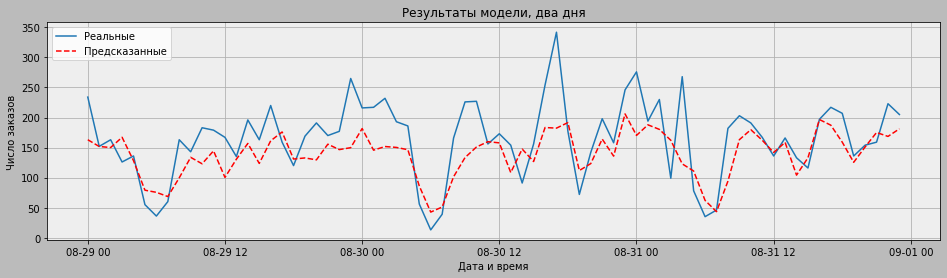

In [42]:
fig = plt.figure(figsize=(16, 4), facecolor='#bbb')
ax = fig.add_subplot(facecolor='#eee')

plt.plot(y_test['2018-08-29':'2018-08-31'], label='Реальные')
plt.plot(pd.Series(grid_cbr.predict(X_test), index = y_test.index)['2018-08-29':'2018-08-31'], 'r--', 
         label='Предсказанные')
plt.grid()
plt.title('Результаты модели, два дня')
plt.xlabel('Дата и время')
plt.ylabel('Число заказов')
plt.legend(loc='upper left');

**Общий вывод:** провели анализ временного ряда с данными о количестве заказов, проведя перед этим предподготовку. По итогам анализа были найдены: сезонность дня и недели, а также определили меняющийся тренд. Добавили необходимые признаки для обучения. Были проверены три модели: RandomForestRegressor, CatBoostRegressor, XGBRegressor. По итогам обучения определили лучшую модель, ей оказалась CatBoostRegressor, а также ранжировали признаки по силе влияния на обучение модели. По итогам тестирования получили RMSE 43.26, что  превосходит заданный уровень. На графике видно, что в некоторые часы есть расхождения, но они не имеют какой либо закономерности.